<a href="https://colab.research.google.com/github/shernee/04_cmpe258/blob/main/3layer_NN_lightningTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 5.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# initialize input parameters
n = 150
d = 3

# initialize random input data, weights and bias
x = torch.rand(n, d).float()
weights_true = torch.tensor([[3.0, -2.0, 4.0], ]).T
bias_true = torch.tensor([[1.8]])

print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}')

# non-linear equation
y_true = torch.einsum('ij, jk -> ik', (x**3), weights_true) + torch.einsum('ij, jk -> ik', (x**2), weights_true) - torch.einsum('ij, jk -> ik', x, weights_true) + bias_true

print(f'y: {y_true.shape}')

x: torch.Size([150, 3]), weights: torch.Size([3, 1]), bias: torch.Size([1])
y: torch.Size([150, 1])


In [ ]:
# class for our entire non-linear model

class Model(pl.LightningModule):
  def __init__(self, input_dim: int, hidden_dim: int, output_dim: int = 1):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.relu2 = nn.ReLU()
    self.linear3 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3

  def training_step(self, batch):
    x, y_true = batch
    y_predicted = self(x)
    loss_value = nn.MSELoss()(y_predicted, y_true)
    return loss_value

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    return optimizer

In [ ]:
# initialize model parameters
input_dim = d
hidden_dim = 10
output_dim = 1
lr = 0.1
num_epochs = 40
batch_size = 10

data_tensor = TensorDataset(x, y_true)
data_loader = DataLoader(data_tensor, batch_size=batch_size, shuffle=True)

trainer = pl.Trainer(max_epochs=num_epochs)
model = Model(input_dim, hidden_dim, output_dim, )

trainer.fit(model, data_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 40    
1 | relu1   | ReLU   | 0     
2 | linear2 | Linear | 110   
3 | relu2   | ReLU   | 0     
4 | linear3 | Linear | 11    
-----------------------------------
161       Trainable params
0         Non-trainable params
161       Total params
0.001     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if y

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


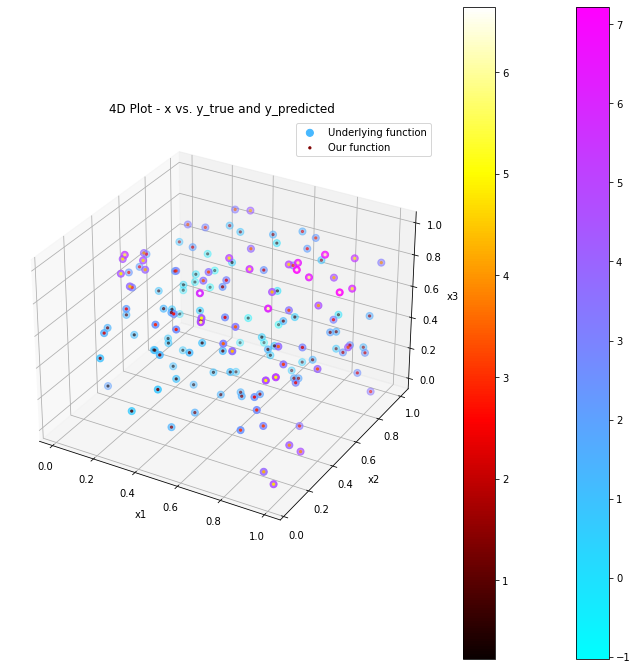

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
scatter_fig = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_true, cmap='cool', label='Underlying function', s=50)
fig.colorbar(scatter_fig)
scatter_fig = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=model(x).detach().numpy(), cmap='hot', label='Our function', marker='.')
fig.colorbar(scatter_fig)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('4D Plot - x vs. y_true and y_predicted')

plt.legend()